# 恒星，星系和类星体分类

’Galaxy', 'Stars', 'Quasars’

在SDSS DR16数据集中对恒星，星系和类星体进行分类的能力，该数据集包含100,000个带标签的样本和17个特征。

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 防止matplotlib画图中中文出现方格  SimHei黑体，KaiTi楷体
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#  查看数据

 ## 饼形图
 
ax = plt.subplots()

ax.pie()

In [46]:
def pieChart(sdss_df):  # 饼形图
    
    '''绘制饼图以获取标签数量.'''
    label_counts = sdss_df['class'].value_counts()  # DataFrame['Unit Name'].value_counts() 查看表格某列中有多少个不同值，并计算每个不同值有在该列中有多少重复值
    colors = ['skyblue', 'red', 'gold']
    fig1, ax1 = plt.subplots()
    ax1.pie(label_counts, labels=['Galaxy', 'Stars', 'Quasars'], autopct='%1.2f%%', startangle=45, colors=colors) # 画饼状图，并指定标签和对应颜色
    ax1.axis('equal')  # axis equal 将横轴纵轴的定标系数设成相同值
    plt.title('SDSS Object Classes')
    plt.show()

 ## 分布直方图
 
seaborn.distplot()

In [47]:
def distribution(sdss_df, axes, feature, row):
    
    '''Plot the distribution of a space object w.r.t. a given feature.'''
    labels = np.unique(sdss_df['class'])  # np.unique( ) 去除数组中的重复数字,并进行排序之后输出
    colors = ['skyblue', 'gold', 'red']
    
    for i in range(len(labels)):
        label = labels[i]
        # pandas.DataFrame.loc()使用column名和index名进行定位
        # 分布直方图 seaborn.distplot
        ax = sns.distplot(sdss_df.loc[sdss_df['class']==label, feature], kde=False, bins=30, ax=axes[row, i], color=colors[i])
        ax.set_title(label)
        if (i == 0):
            ax.set(ylabel='Count')

 ## 回归图
 
 seaborn.lmplot(x, y, data, hue="") 
 
 x, y strings, optional: data数据中，行的名字。data : DataFrame数据, hue 在所在列中分类
 

In [48]:
def equitorial(sdss_df, row):
    
    '''绘制观测赤道坐标.'''
    labels = np.unique(sdss_df['class'])
    colors = ['skyblue', 'gold', 'red']
    label = labels[row]
    # seaborn.lmplot() 绘制回归图
    sns.lmplot(x='ra', y='dec', data=sdss_df.loc[sdss_df['class']==label],hue='class', palette=[colors[row]], scatter_kws={'s': 2}, 
               fit_reg=False, height=4, aspect=2)
    plt.ylabel('dec')
    plt.title('赤道坐标')

In [49]:
def main():

    # read in SDSS data
    filepath = 'Skyserver_12_30_2019 4_49_58 PM.csv'
    sdss_df = pd.read_csv(filepath, encoding='utf-8')

    # define lists of relevant features
    geo = ['ra', 'dec']  # 经纬度
    nonugriv = ['redshift', 'plate', 'mjd', 'fiberid']
    ugriv = ['u', 'g', 'r', 'i', 'z']

    # 绘制标签计数饼图
    pieChart(sdss_df)

    # 绘制观测的赤道坐标
    for row in range(3):
        equitorial(sdss_df, row)
        plt.show()
    
    # plot the distribution of non-geo and non-ugriv features
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 14))
    plt.subplots_adjust(wspace=.4, hspace=.4)
    for row in range(len(nonugriv)):
        feat = nonugriv[row]
        distribution(sdss_df, axes, feat, row)
    plt.show()
        
    # plot the distribution of ugriv features
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
    plt.subplots_adjust(wspace=.4, hspace=.4)
    for row in range(len(ugriv)):
        feat = ugriv[row]
        distribution(sdss_df, axes, feat, row)
    plt.show()

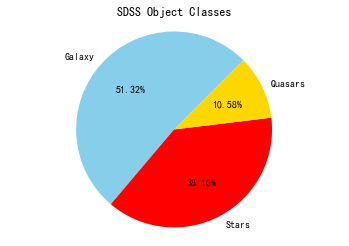

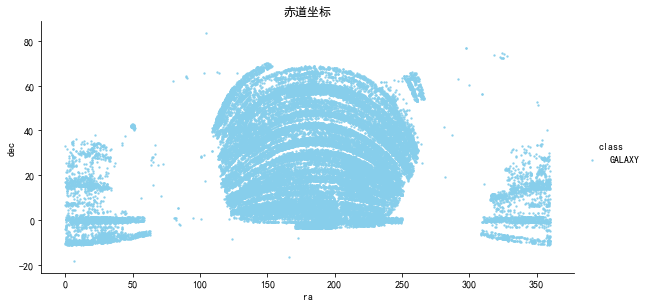

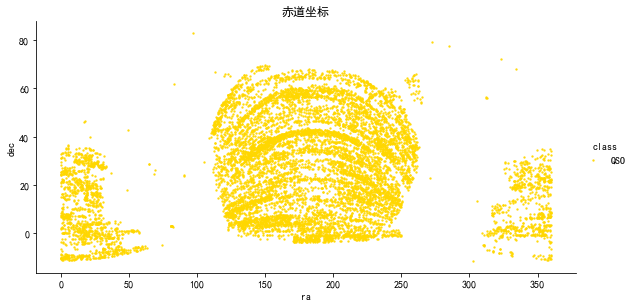

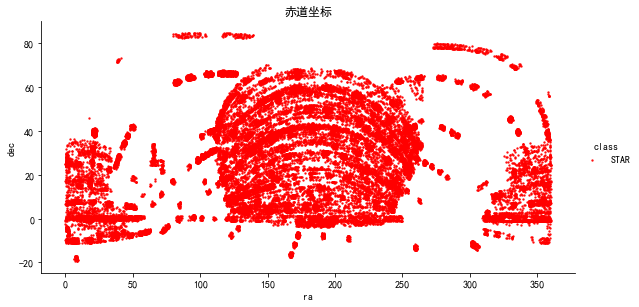

C:\Users\Administrator\anaconda3\envs\py38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



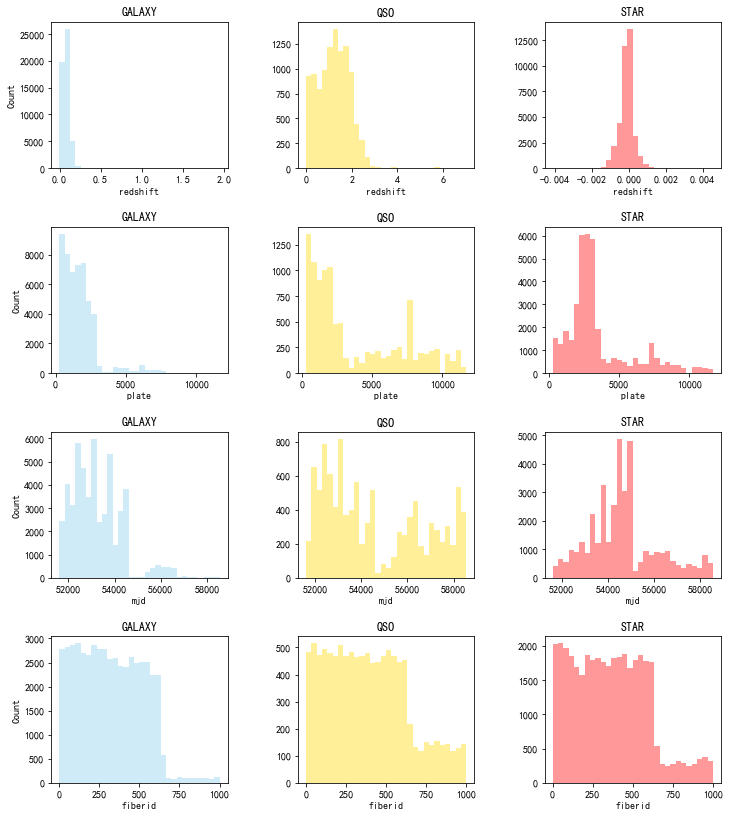

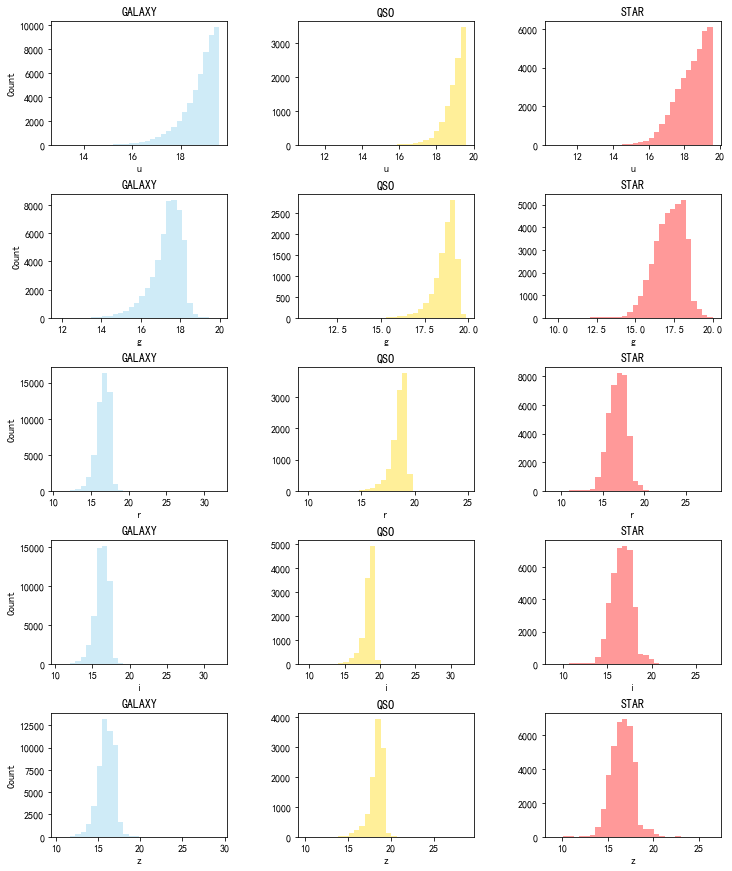

In [50]:
main()

红移似乎很好地说明了观察对象的类别。每个类别的轴都大不相同。这是有道理的,因为红移是由于观察物体以很快的速度离开观察者而产生的。星星飞快地离开我们。星系以更快的速度远离我们；类星体以更快的速度远离我们。

相对于类星体和恒星，观察到的大部分星系的 plate number 和 fiber ID 均较低。

ugriv变量的类之间的分布看起来相同，并且类之间存在差异，但微妙。值得注意的是，每个ugriv特征（即band）通常是相互关联的，因此，在进行任何ML之前，都应对这些特征进行一些额外的处理。

# 随机森林

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 随机读入数据

In [52]:
filename = 'Skyserver_12_30_2019 4_49_58 PM.csv'
sdss_df = pd.read_csv(filename, encoding='utf-8')
sdss_df = sdss_df.sample(frac=1)

# 删除不重要的列
sdss_df = sdss_df.drop(['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field'], axis=1)
sdss_df.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
16030,133.290426,51.353448,18.21098,17.28508,16.99652,16.86947,16.84626,STAR,-0.000149,7303,57013,874
67255,181.589354,8.755899,18.64365,17.45597,17.00224,16.83567,16.77694,STAR,0.000159,1623,53089,575
85315,155.490846,24.655200,16.83057,14.89387,14.05722,13.64724,13.30192,GALAXY,0.040217,2349,53734,356
89112,170.446199,26.965724,19.07488,17.72824,17.00595,16.64464,16.33985,GALAXY,0.118508,2216,53795,467
38818,174.492018,42.408457,19.10103,18.97920,18.92038,18.65551,18.66460,QSO,1.710534,1443,53055,624


## 划分数据集

训练占60％，验证占20％，测试占20％

In [53]:
train_count = 60000
val_count = 20000
test_count = 20000

train_df = sdss_df.iloc[:train_count]  # 训练集
validation_df = sdss_df.iloc[train_count:train_count+val_count]  # 验证集
test_df = sdss_df.iloc[-test_count:]   # 测试集

##  去掉标签

In [54]:
X_train = train_df.drop(['class'], axis=1)
X_validation = validation_df.drop(['class'], axis=1)
X_test = test_df.drop(['class'], axis=1)

In [60]:
X_train.head(2)

,ra,dec,u,g,r,i,z,redshift,plate,mjd,fiberid
16030,133.290426,51.353448,18.21098,17.28508,16.99652,16.86947,16.84626,-0.000149,7303,57013,874
67255,181.589354,8.755899,18.64365,17.45597,17.00224,16.83567,16.77694,0.000159,1623,53089,575


## LabelEncoder对特征进行硬编码

from sklearn.preprocessing import LabelEncoder

在使用LabelEncoder之前要对数据进行缺失值处理，比如fillna("None)，不然编码的时候会报错

In [61]:
le = LabelEncoder()
labels = le.fit_transform(sdss_df['class'])

In [62]:
y_train = labels[:train_count]
y_validation = labels[train_count:train_count+val_count]
y_test = labels[-test_count:]

In [63]:
y_test

array([1, 2, 0, ..., 0, 0, 2])

## 数据缩放  标准化

from sklearn.preprocessing import StandardScaler  

StandardScaler类是一个用来讲数据进行归一化和标准化的类。标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导  

样本x的标准分数计算如下：z = (x - u) / s

标准化数据通过减去均值然后除以方差（或标准差），这种数据标准化方法经过处理后数据符合标准正态分布，即均值为0，标准差为1。

适用于：如果数据的分布本身就服从正态分布，就可以用这个方法。

In [64]:
scaler = StandardScaler()
scaler.fit(X_train) # 只在训练集中缩放数据  fit()就是计算标准化所用到的均值与方差

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)  # 利用fit（）的结果作为参数对数据进行相应的处理
X_validation = pd.DataFrame(scaler.transform(X_validation), columns=X_validation.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_validation.columns)

In [66]:
X_train.var()

ra          1.000017
dec         1.000017
u           1.000017
g           1.000017
r           1.000017
i           1.000017
z           1.000017
redshift    1.000017
plate       1.000017
mjd         1.000017
fiberid     1.000017
dtype: float64

## 将PCA主成分分析应用于波长强度

In [67]:
pca = PCA(n_components=3)
dfs = [X_train, X_validation, X_test]
for i in range(len(dfs)):
    df = dfs[i]
    ugriz = pca.fit_transform(df[['u', 'g', 'r', 'i', 'z']])
    df = pd.concat((df, pd.DataFrame(ugriz)), axis=1)
    df.rename({0: 'PCA1', 1: 'PCA2', 2: 'PCA3'}, axis=1, inplace=True)
    df.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
    dfs[i] = df
X_train, X_validation, X_test = dfs

In [68]:
X_train.var()

ra          1.000017
dec         1.000017
redshift    1.000017
plate       1.000017
mjd         1.000017
fiberid     1.000017
PCA1        4.384545
PCA2        0.557779
PCA3        0.028852
dtype: float64

## 随机森林模型 及其准确率

RandomForestClassifier(n_estimators)

n_estimators  森林里（决策）树的数目

https://blog.csdn.net/w952470866/article/details/78987265/

In [69]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_validation)
model_acc = (preds == y_validation).sum().astype(float) / len(preds) * 100

print('Validation Accuracy: %3.5f' % (model_acc))

Validation Accuracy: 98.33500


# 评估随机森林模型

In [71]:
preds = rfc.predict(X_test)  # 测试集
model_acc = (preds == y_test).sum().astype(float) / len(preds) * 100

print('Test Accuracy: %3.5f\n' % (model_acc))

Test Accuracy: 98.31000



## 分析随机森林模型中的特征重要性

In [72]:
importances = pd.DataFrame({
    'Feature': X_validation.columns,
    'Importance': rfc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
print(importances)

          Importance
Feature             
redshift    0.609277
PCA3        0.123197
PCA1        0.089482
PCA2        0.080187
plate       0.058703
mjd         0.025432
ra          0.006342
dec         0.004664
fiberid     0.002716


红移与天文物体标签高度相关（重要性为58.3％）。接下来的三个最重要的功能是PCA，尽管这些功能的影响远不如redshift。

## 混淆矩阵

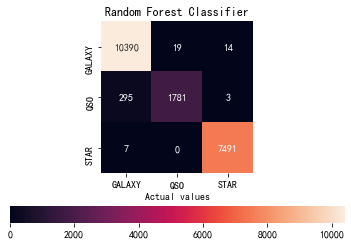

In [75]:
labels = np.unique(sdss_df['class'])

ax = plt.subplot(1, 1, 1)
ax.set_aspect(1)
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = labels,
            yticklabels = labels, cbar_kws={'orientation': 'horizontal'})
plt.xlabel('Actual values')
plt.title('Random Forest Classifier')

plt.show()

## 精确率和召回率

In [76]:
precision = np.diag(cm) / np.sum(cm, axis = 0)
recall = np.diag(cm) / np.sum(cm, axis = 1)

print('Recall: ', precision)
print('Precision: ', recall)

Recall:  [0.97175458 0.98944444 0.99773575]
Precision:  [0.99683392 0.85666186 0.99906642]


### 模型在星系和恒星上的性能要比类星体好得多。这是合理的，因为类星体在100,000个样本中是少数。

星系Galaxies的精度为99.6％，召回率为99.0％。

类星体Quasars 的精度为85.7％，召回率为98.9％。

恒星Stars 的精度为99.9％和99.7％
